# NN2
Tymoteusz Urban

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import copy
from tqdm import tqdm

In [143]:
class NeuralNetwork:
    
    """
    Implementation of multi layer perceptron

    Attributes
    -----------
    layers : List
    
    """
    
    def __init__(self, layers, weights=None, biases=None, activations=None, initalization='xavier'):
        """
        activations - available functions: 'sigmoid', 'linear'
        initialization - available types: 'xavier', 'he', 'uniform'
        """
        self.layers = layers
        self.num_layers = len(layers)
        
        initialization_functions = {
            'xavier': self.xavier_init,
            'he': self.he_init,
            'uniform': self.uniform_init
        }
        self.init_function = initialization_functions.get(initalization)
        
        if weights is None:
            self.weights = [self.init_function(layers[i-1], layers[i]) for i in range(1, self.num_layers)]
        else:
            self.weights = weights
        
        if biases is None:
            self.biases = [self.init_function(layers[i]) for i in range(1, self.num_layers)]
        else:
            self.biases = biases
        
        if activations is None:
            self.activations = ['sigmoid' for i in range(1, self.num_layers - 1)] + ['linear']
        else:
            self.activations = activations
        
        activation_functions = {
            'sigmoid': self._sigmoid,
            'linear': self._linear
        }
        self.activation_funcs = list(map(lambda x: activation_functions.get(x), self.activations))
        
        self.mean = None
        self.std = None
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _linear(self, z):
        return z
    
    def xavier_init(self, n_in, n_out=None):
        if n_out is None:
            n_out = n_in
            variance = 1 / n_out
            stddev = np.sqrt(variance)
            return np.random.normal(0, stddev, n_out)
        variance = 2 / (n_in + n_out)
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
        
    def he_init(self, n_in, n_out=None):
        if n_out is None:
            variance = 2 / n_in
            stddev = np.sqrt(variance)
            return np.random.normal(0, stddev, n_in)
        variance = 2 / n_in
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
    
    def zeros_init(self, n_in, n_out=None):
        if n_out is None:
            return np.zeros(n_in)
        return np.zeros((n_in, n_out))
    
    def uniform_init(self, n_in, n_out=None):
        if n_out is None:
            return np.random.uniform(0, 1, n_in)
        return np.random.uniform(0, 1, (n_in, n_out))
    
    def feedforward(self, a, return_activations=False):
        if return_activations:
            activations = [a]
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
                activations.append(a)
            return activations
        else:
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
            return a
    
    def predict(self, X):
        return self.feedforward(X)
    
    def mse(self, X, y, resize=False, denormalize=None):
        """
        first predictions are made, then denormalized and then mse is calculated
        
        denormalize - a tuple (mean, std)
        """
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
        predictions = self.predict(X)
        if denormalize:
            predictions = destandardize_data(predictions, denormalize)
        return np.mean((predictions - y) ** 2)
    
    def sigmoid_derivative(self, a):
        """calculates sigm'(z) where a = sigm(z)"""
        return a * (1-a)
    
    def backward(self, X, y, learning_rate):
        """backpropagation, returns partial derevatives"""
        # feedforward
        activations = self.feedforward(X, return_activations=True)
        deltas = [None] * len(self.weights)
        # output error
        deltas[-1] = activations[-1] - y.reshape(-1, 1)
        # calculate neurons' errors using backpropagation 
        for i in reversed(range(len(deltas) - 1)):
            if self.activations[i] == "sigmoid":
                # calculate error delta_l = delta_{l+1} x w_{l+1} * sigmoid'(a_{l+1})
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T) * self.sigmoid_derivative(activations[i+1])
            elif self.activations[i] == "linear":
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T)
        
        L = len(self.weights)
        weights_gradient = [None] * L
        biases_gradient = [None] * L
        # calculate partial derevatives of cost function
        for i in range(L):
            # activations array is longer (so activations[l] in reality is a_{l-1})
            # weights_gradient[i] = np.sum('ij,jk->ijk', activations[i].T, deltas[i]) # to samo, ale dot 10x razy szybszy
            weights_gradient[i] = np.dot(activations[i].T, deltas[i])
            biases_gradient[i] = np.sum(deltas[i], axis=0)
            
        return weights_gradient, biases_gradient
        
    def update_weights(self, X, y, learning_rate):
        """
        updates weights using gradient descent
        """
        m = len(X)
        weights_gradient, biases_gradient = self.backward(X, y, learning_rate)
        for i in range(len(self.weights)):
            self.weights[i] -= (learning_rate/m) * weights_gradient[i]
            self.biases[i] -= (learning_rate/m) * biases_gradient[i]
    
    def create_batches(self, X, y, batch_size):
        N = len(X)
        combined_data = np.array(list(zip(X, y)))
        np.random.shuffle(combined_data)

        X_shuffled = np.array(list(zip(*combined_data))[0])
        y_shuffled = np.array(list(zip(*combined_data))[1])

        X_mini_batches = [X_shuffled[k:k+batch_size] for k in range(0, N, batch_size)]
        y_mini_batches = [y_shuffled[k:k+batch_size] for k in range(0, N, batch_size)]
        return X_mini_batches, y_mini_batches
        
    def train(self, X, y, learning_rate=0.001, epochs=10000, batch_size=None, return_history=False,
              X_test=None, y_test=None, cutoff=None, resize=False, denormalize=None, info_interval=500, mute_print=False):
        """
        To test and print MSE on testset, X_test and y_test need to be provided
        To set early stopping, provide cutoff (and test sets)
        denormalize - a tuple (mean, std) for denormalizing target for calculating mse
        info_interval - number of epochs between logging, set to None to turn off console output
        """
        test_mse = False
        if X_test is not None and y_test is not None:
            test_mse = True
        early_stopping = False
        if test_mse and cutoff is not None:
            early_stopping = True
        
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
            if test_mse:
                X_test = X_test.to_numpy().reshape(-1, 1)
                y_test = y_test.to_numpy().reshape(-1, 1)
            
        if batch_size is None:
            batch_size = len(X)
        
        y_mse = y
        if denormalize is not None:
            y_mse = destandardize_data(y, denormalize)
            
        history = History()
        
        for epoch in range(1, epochs+1):
            
            if batch_size < len(X):
                batches_x, batches_y = self.create_batches(X, y, batch_size)
                for i in range(len(batches_x)):
                    self.update_weights(batches_x[i], batches_y[i], learning_rate)
            else:
                self.update_weights(X, y, learning_rate)
            
            if info_interval is not None and epoch % info_interval == 0:
                loss = self.mse(X, y_mse, denormalize=denormalize)    
                history.loss.append(loss)
                history.loss_epochs.append(epoch)
                training_info = f"Epoch {epoch}: Loss = {round(loss, 3)}"
                if test_mse:
                    loss_test = self.mse(X_test, y_test, denormalize=denormalize)
                    training_info += f" Test Loss = {round(loss_test, 3)}"
                if not mute_print:
                    print(training_info)
            
            history.weights.append(copy.deepcopy(self.weights))
            history.biases.append(copy.deepcopy(self.biases))
            # history.append([copy.deepcopy(self.weights), copy.deepcopy(self.biases)])
            
            if early_stopping:
                loss_es = self.mse(X_test, y_test, denormalize=denormalize)
                if loss_es < cutoff:
                    loss = self.mse(X, y_mse, denormalize=denormalize)    
                    training_info = f"Epoch {epoch}: Loss = {round(loss, 3)}"
                    loss_test = self.mse(X_test, y_test, denormalize=denormalize)
                    training_info += f" Test Loss = {round(loss_test, 3)}"
                    print(training_info)
                    break
        
        if return_history:
            return history

def standardize_data(X):
    """
    returns:
    X_new - standardized X
    a tuple (mean, std) - normal distribution parameters from X for destandarizing
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_new = (X - mean) / std
    return X_new, (mean, std)

def destandardize_data(X, parameters):
    """parameters: a tuple (mean, std)"""
    return X * parameters[1] + parameters[0]

    
class History:
    """
    Class which attributes are weights from all training epochs 
    and loss for chosen loss_epochs (usually epochs with some interval)
    """
    
    def __init__(self):
        self.weights = []
        self.biases = []
        self.loss = []
        self.test_loss = []
        self.loss_epochs = []
    
    def plot_weights(self, layer, bias=False, return_plot=False):
        """
        layer - integer, index of weights vector
        if to plot bias instead of weights 
        """
        weights = []
        weights_type = 'Weights'
        if bias:
            weights_type = 'Biases'
            for epoch in self.biases:
                weights.append(epoch[layer].flatten())
        else:
            for epoch in self.weights:
                weights.append(epoch[layer].flatten())

        weights = np.array(weights)
        for i in range(weights.shape[1]):
            w_y = weights[:,i]
            plt.plot(range(len(self.weights)), w_y)
            
        plt.xlabel('Epochs')
        plt.title(f'{weights_type} values vs epochs at layer {layer}')
        if return_plot:
            return plt
        else:
            plt.show()
        
    def plot_loss(self, test=False, return_plot=False):
        if test:
            plt.plot(self.loss_epochs, self.test_loss)
            plt.title('Test loss history')
        else:
            plt.plot(self.loss_epochs, self.loss)
            plt.title('Training loss history')
        plt.xlabel('Epochs')
        plt.ylabel('MSE')
        if return_plot:
            return plt
        else:
            plt.show()

## Kryteria MSE

### Zbiór square-simple

In [16]:
square_simple = pd.read_csv("../dane/regression/square-simple-test.csv", index_col=0)
square_simple_train = pd.read_csv("../dane/regression/square-simple-training.csv", index_col=0)

In [44]:
mlp = NeuralNetwork([1,10,1])
y_norm, parameters = standardize_data(square_simple_train['y'])
history = mlp.train(square_simple_train['x'], y_norm, learning_rate=0.1, epochs=8000, batch_size=25, return_history=True, resize=True,
                   X_test=square_simple['x'], y_test=square_simple['y'], cutoff=None, denormalize=parameters, info_interval=200)

Epoch 200: Loss = 1747.73 Test Loss = 1193.868
Epoch 400: Loss = 286.065 Test Loss = 227.572
Epoch 600: Loss = 140.515 Test Loss = 116.591
Epoch 800: Loss = 70.403 Test Loss = 62.898
Epoch 1000: Loss = 41.115 Test Loss = 39.952
Epoch 1200: Loss = 27.1 Test Loss = 28.451
Epoch 1400: Loss = 18.989 Test Loss = 20.956
Epoch 1600: Loss = 13.901 Test Loss = 14.958
Epoch 1800: Loss = 10.438 Test Loss = 11.868
Epoch 2000: Loss = 8.112 Test Loss = 9.803
Epoch 2200: Loss = 6.531 Test Loss = 8.15
Epoch 2400: Loss = 5.425 Test Loss = 6.877
Epoch 2600: Loss = 4.66 Test Loss = 5.933
Epoch 2800: Loss = 4.091 Test Loss = 5.327
Epoch 3000: Loss = 3.71 Test Loss = 5.139
Epoch 3200: Loss = 3.403 Test Loss = 4.431
Epoch 3400: Loss = 3.176 Test Loss = 4.418
Epoch 3600: Loss = 2.989 Test Loss = 4.001
Epoch 3800: Loss = 2.849 Test Loss = 3.918
Epoch 4000: Loss = 2.739 Test Loss = 3.792
Epoch 4200: Loss = 2.652 Test Loss = 3.696
Epoch 4400: Loss = 2.566 Test Loss = 3.557
Epoch 4600: Loss = 2.497 Test Loss = 3

In [45]:
print("MSE:", mlp.mse(square_simple['x'], square_simple['y'], resize=True, denormalize=parameters))

MSE: 2.5450217960736357


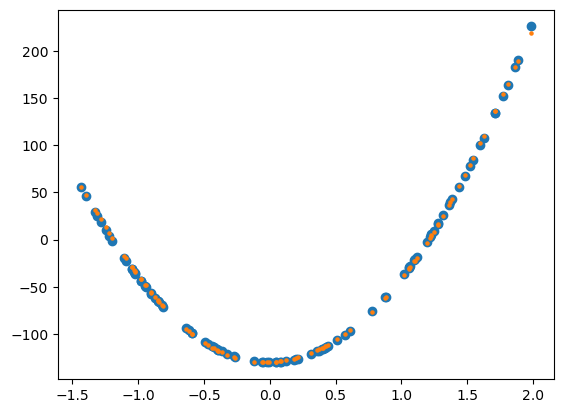

In [46]:
y_pred = mlp.predict(square_simple['x'].to_numpy().reshape(-1,1))
y_pred = destandardize_data(y_pred, parameters=parameters)
plt.scatter(square_simple['x'], square_simple['y'])
plt.scatter(square_simple['x'], y_pred, s=5)
plt.show()

### Zbiór steps-small

In [5]:
steps_small_test = pd.read_csv("../dane/regression/steps-small-test.csv", index_col=0)
steps_small_train = pd.read_csv("../dane/regression/steps-small-training.csv", index_col=0)

In [118]:
mlp_steps = NeuralNetwork([1,5,5,1], initalization='he')
y_norm_steps, parameters_steps = standardize_data(steps_small_train['y'])
history_steps = mlp_steps.train(steps_small_train['x'], y_norm_steps, learning_rate=1, epochs=200000, return_history=True,
                                resize=True, X_test=steps_small_test['x'], y_test=steps_small_test['y'], cutoff=4,
                                denormalize=parameters_steps, info_interval=5000)

Epoch 5000: Loss = 281.546 Test Loss = 332.531
Epoch 10000: Loss = 98.206 Test Loss = 197.07
Epoch 15000: Loss = 126.465 Test Loss = 156.401
Epoch 20000: Loss = 89.436 Test Loss = 130.714
Epoch 25000: Loss = 55.888 Test Loss = 111.27
Epoch 30000: Loss = 36.077 Test Loss = 100.882
Epoch 35000: Loss = 26.482 Test Loss = 95.721
Epoch 40000: Loss = 22.532 Test Loss = 93.218
Epoch 45000: Loss = 21.011 Test Loss = 92.076
Epoch 50000: Loss = 20.134 Test Loss = 91.582
Epoch 55000: Loss = 19.221 Test Loss = 91.359
Epoch 60000: Loss = 18.144 Test Loss = 91.268
Epoch 65000: Loss = 16.93 Test Loss = 91.277
Epoch 70000: Loss = 15.619 Test Loss = 91.384
Epoch 75000: Loss = 14.24 Test Loss = 91.601
Epoch 80000: Loss = 12.813 Test Loss = 91.944
Epoch 85000: Loss = 11.366 Test Loss = 92.441
Epoch 90000: Loss = 9.947 Test Loss = 93.128
Epoch 95000: Loss = 8.622 Test Loss = 94.035
Epoch 100000: Loss = 7.455 Test Loss = 95.157
Epoch 105000: Loss = 6.475 Test Loss = 96.451
Epoch 110000: Loss = 5.672 Test L

Test MSE: 118.67195513346338
Train MSE: 0.7333836701199743


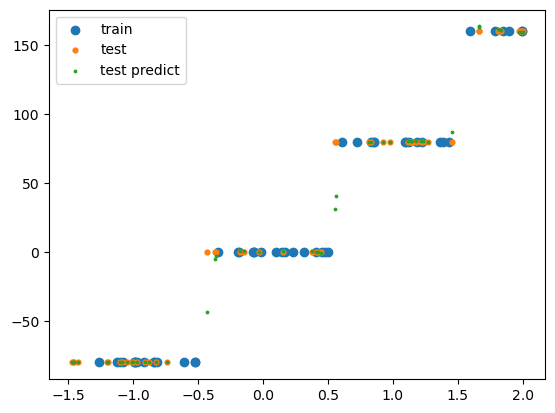

In [125]:
preds_steps = mlp_steps.predict(steps_small_test['x'].to_numpy().reshape(-1,1))
preds_steps_denorm = destandardize_data(preds_steps, parameters_steps)
plt.scatter(steps_small_train['x'], steps_small_train['y'])
plt.scatter(steps_small_test['x'], steps_small_test['y'], s=12)
plt.scatter(steps_small_test['x'], preds_steps_denorm, s=3)
print('Test MSE:', mlp_steps.mse(steps_small_test['x'], steps_small_test['y'], resize=True, denormalize=parameters_steps))
print('Train MSE:', mlp_steps.mse(steps_small_train['x'], steps_small_train['y'], resize=True, denormalize=parameters_steps))
plt.legend(['train', 'test', 'test predict'])
plt.show()

Problem jest taki, że poziomy w zbiorze testowym są 'szersze' niż w treningowym, więc sieć nie wie, że musi w tym miejscu mieć jakąś określoną wartość.

Wytrenujmy zatem naszą sieć na zbiorze steps-large, który pokrywa wszystkie punkty:

In [3]:
steps_large_train = pd.read_csv("../dane/regression/steps-large-training.csv", index_col=0)

In [7]:
mlp_steps_l = NeuralNetwork([1,5,5,1], initalization='he')
y_norm_steps_l, parameters_steps_l = standardize_data(steps_large_train['y'])
history_steps_l = mlp_steps_l.train(steps_large_train['x'], y_norm_steps_l, learning_rate=1, epochs=20000, batch_size=100, 
                                    return_history=True, resize=True, X_test=steps_small_test['x'], y_test=steps_small_test['y'],
                                    cutoff=4, denormalize=parameters_steps_l, info_interval=100)

Epoch 100: Loss = 381.604 Test Loss = 294.023
Epoch 200: Loss = 157.646 Test Loss = 98.299
Epoch 300: Loss = 114.635 Test Loss = 53.109
Epoch 400: Loss = 97.99 Test Loss = 40.214
Epoch 500: Loss = 91.784 Test Loss = 34.222
Epoch 600: Loss = 76.358 Test Loss = 24.821
Epoch 700: Loss = 72.666 Test Loss = 18.396
Epoch 800: Loss = 64.162 Test Loss = 13.364
Epoch 900: Loss = 61.351 Test Loss = 10.912
Epoch 1000: Loss = 61.354 Test Loss = 10.457
Epoch 1100: Loss = 62.217 Test Loss = 16.026
Epoch 1200: Loss = 54.618 Test Loss = 7.159
Epoch 1300: Loss = 53.146 Test Loss = 6.966
Epoch 1400: Loss = 54.874 Test Loss = 9.379
Epoch 1500: Loss = 45.957 Test Loss = 4.472
Epoch 1503: Loss = 46.485 Test Loss = 3.997


Test MSE: 3.997212382492845


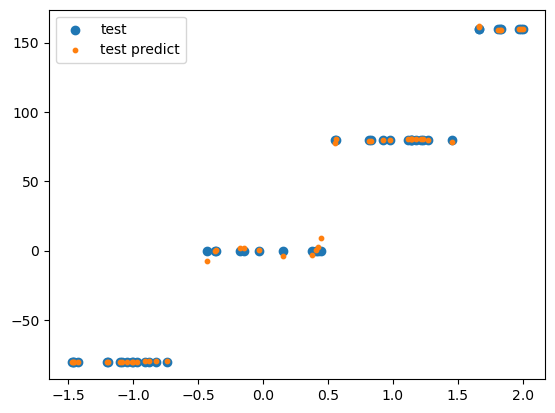

In [11]:
preds_steps = mlp_steps_l.predict(steps_small_test['x'].to_numpy().reshape(-1,1))
preds_steps_denorm = destandardize_data(preds_steps, parameters_steps_l)
plt.scatter(steps_small_test['x'], steps_small_test['y'])
plt.scatter(steps_small_test['x'], preds_steps_denorm, s=10)
print('Test MSE:', mlp_steps_l.mse(steps_small_test['x'], steps_small_test['y'], resize=True, denormalize=parameters_steps_l))
plt.legend(['test', 'test predict'])
plt.show()

### Zbiór multimodal-large

In [73]:
multimodal_test = pd.read_csv("../dane/regression/multimodal-large-test.csv", index_col=0).reset_index()
multimodal_train = pd.read_csv("../dane/regression/multimodal-large-training.csv", index_col=0).reset_index()

In [142]:
mlp_modal = NeuralNetwork([1,10,10,1], initalization='xavier')
y_norm_modal, parameters_modal = standardize_data(multimodal_train['y'])
history_modal = mlp_modal.train(multimodal_train['x'], y_norm_modal, learning_rate=1, epochs=100000, return_history=True,
                                resize=True, X_test=multimodal_test['x'], y_test=multimodal_test['y'], cutoff=30,
                                denormalize=parameters_modal, info_interval=1000)

Epoch 1000: Loss = 2072.824 Test Loss = 2061.447
Epoch 2000: Loss = 1660.288 Test Loss = 1662.73
Epoch 3000: Loss = 1593.629 Test Loss = 1601.314
Epoch 4000: Loss = 1560.446 Test Loss = 1569.977
Epoch 5000: Loss = 1535.542 Test Loss = 1546.294
Epoch 6000: Loss = 1336.624 Test Loss = 1346.198
Epoch 7000: Loss = 660.518 Test Loss = 688.293
Epoch 8000: Loss = 565.986 Test Loss = 597.867
Epoch 9000: Loss = 534.578 Test Loss = 566.206
Epoch 10000: Loss = 511.731 Test Loss = 542.682
Epoch 11000: Loss = 490.494 Test Loss = 520.97
Epoch 12000: Loss = 492.542 Test Loss = 521.553
Epoch 13000: Loss = 503.228 Test Loss = 529.168
Epoch 14000: Loss = 503.387 Test Loss = 524.493
Epoch 15000: Loss = 475.107 Test Loss = 490.142
Epoch 16000: Loss = 420.17 Test Loss = 429.769
Epoch 17000: Loss = 356.297 Test Loss = 362.666
Epoch 18000: Loss = 293.359 Test Loss = 298.571
Epoch 19000: Loss = 233.567 Test Loss = 238.743
Epoch 20000: Loss = 180.17 Test Loss = 185.811
Epoch 21000: Loss = 155.663 Test Loss = 1

Test MSE: 3.999971466978165


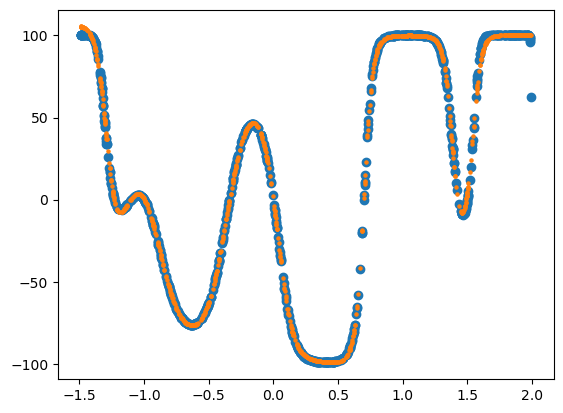

In [153]:
preds_modal = mlp_modal.predict(multimodal_test['x'].to_numpy().reshape(-1,1))
preds_modal_denorm = destandardize_data(preds_modal, parameters_modal)
plt.scatter(multimodal_test['x'], multimodal_test['y'])
plt.scatter(multimodal_test['x'], preds_modal_denorm, s=5)
print('Test MSE:', mlp_modal.mse(multimodal_test['x'], multimodal_test['y'], resize=True, denormalize=parameters_modal))
plt.show()

## Wizualizacja wag

Zaimplementowana funkcja jest metodą klasy History, gdzie przechowywana jest historia wartości wszystkich wag. Wystarczy podać numer warstwy (zaczynając od 0). Przykładowe wizualizacje dla architektury [1,10,1] dla zbioru square-simple.

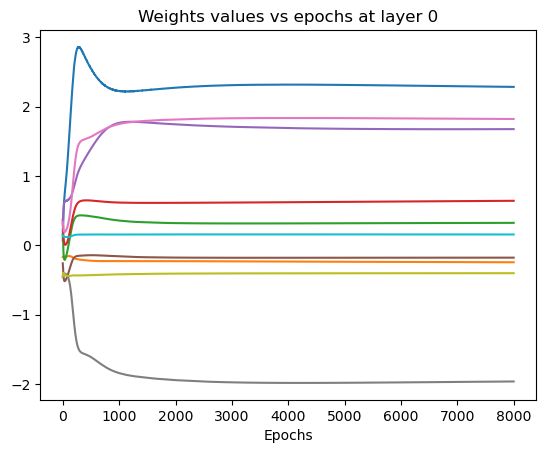

In [47]:
history.plot_weights(layer=0)  # wagi przejścia z 1 neuronu do 10

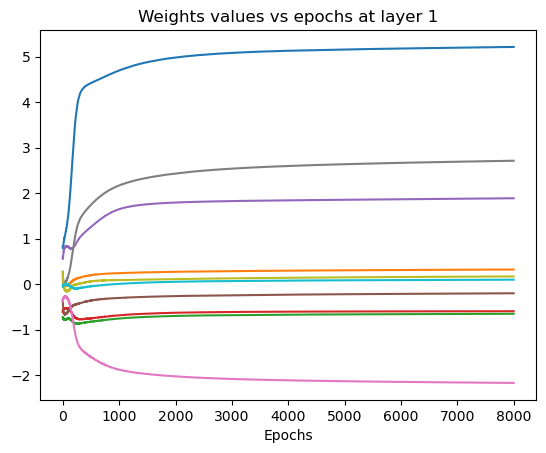

In [48]:
history.plot_weights(layer=1)  # wagi przejścia z warstwy ukrytej do outputu

Na wykresach widać zbieżność. Możemy sprawdzić to samo dla biasów:

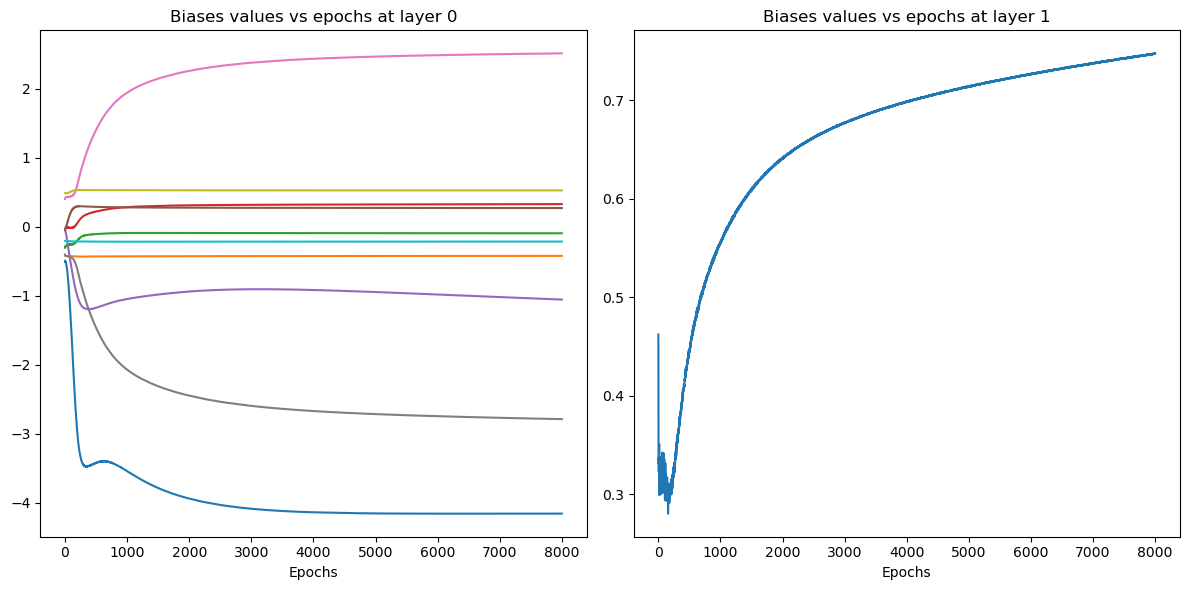

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.sca(axes[0])
history.plot_weights(layer=0, bias=True, return_plot=True)
plt.sca(axes[1])
history.plot_weights(layer=1, bias=True, return_plot=True)
plt.tight_layout()

## Eksperymenty

### Rozmiary batchów

In [13]:
def batch_test(train_set, test_set, batch_sizes, arch, init, lr, epochs, name, interval=1000, cutoff=None):
    y_norm, parameters = standardize_data(train_set['y'])    
    for batch_size in batch_sizes:
        mlp = NeuralNetwork(arch, initalization=init)
        start_time = time.time()
        history = mlp.train(train_set['x'], y_norm, learning_rate=lr, epochs=epochs, batch_size=batch_size, return_history=True,
                                    resize=True, X_test=test_set['x'], y_test=test_set['y'], cutoff=cutoff,
                                    denormalize=parameters, info_interval=interval, mute_print=True)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"size {batch_size}: {round(elapsed_time, 1)} s")
        history.plot_loss()
    plt.suptitle(f"{name}, arch: {arch}, lr={lr}")
    plt.legend(batch_sizes)
    plt.show()

Epoch 519: Loss = 4.414 Test Loss = 4.713
size 5: 0.9 s
Epoch 1740: Loss = 4.255 Test Loss = 4.993
size 10: 2.0 s
Epoch 5622: Loss = 4.375 Test Loss = 4.987
size 25: 4.5 s
Epoch 27252: Loss = 3.861 Test Loss = 4.938
size 50: 18.7 s
Epoch 19899: Loss = 3.773 Test Loss = 5.0
size None: 3.0 s


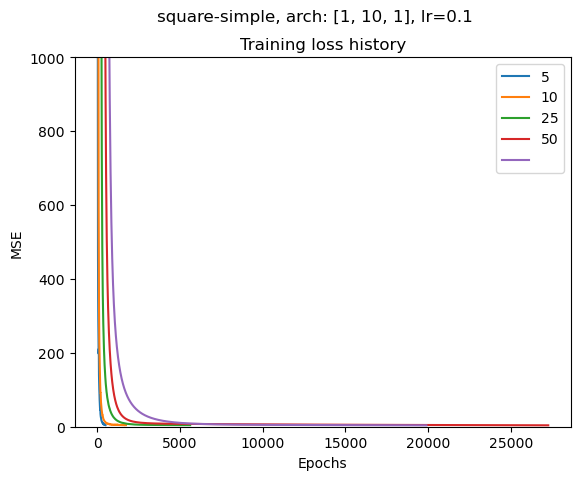

In [87]:
plt.ylim(0,1000)
batch_test(square_simple_train, square_simple, [5, 10, 25, 50, None], [1, 10, 1], 'xavier', lr=0.1, epochs=40000,
           name='square-simple', interval=10, cutoff=5)

Widzimy, że w większości przypadków im mniejszy rozmiar batcha, tym mniej epok jest potrzebnych do osiągnięcia założonego MSE. Oczywiście to co nas także interesuje to czas osiągnięcia celu. Dla tego zbioru i architektury najlepiej spisują sie rozmiary 5, 10 i pełny rozmiar danych.

Epoch 37: Loss = 87.134 Test Loss = 34.003
size 10: 5.4 s
Epoch 149: Loss = 110.597 Test Loss = 38.969
size 50: 12.1 s
Epoch 296: Loss = 96.956 Test Loss = 39.213
size 100: 21.6 s
Epoch 870: Loss = 95.282 Test Loss = 39.948
size 250: 58.0 s


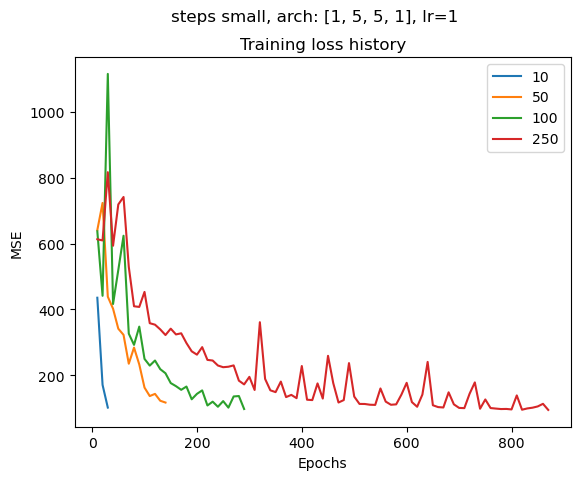

In [18]:
batch_test(steps_large_train, steps_small_test, [10, 50, 100, 250], [1, 5, 5, 1], 'he', lr=1, epochs=100000,
           name='steps small', interval=10, cutoff=40)

Tutaj widzimy, że im mniejszy rozmiar batcha, tym algorytm szybciej zbiega

Epoch 44173: Loss = 94.919 Test Loss = 39.999
size None: 103.1 s


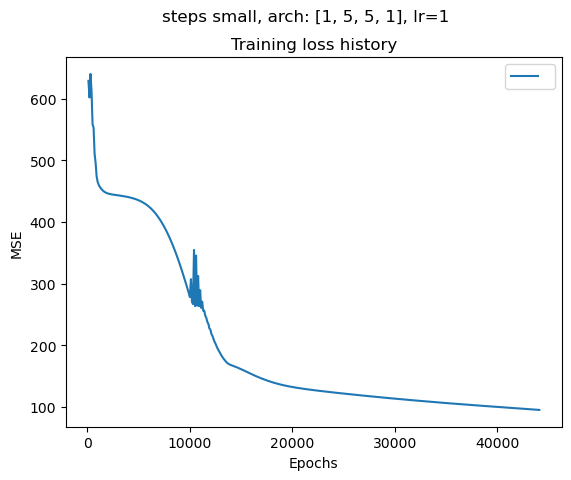

In [19]:
batch_test(steps_large_train, steps_small_test, [None], [1, 5, 5, 1], 'he', lr=1, epochs=100000,
           name='steps small', interval=100, cutoff=40)

Oddzielny wykres dla pełnej porcji danych, gdyż ta sieć potrzebuje o wiele większej liczby epok.

Epoch 649: Loss = 84.222 Test Loss = 78.77
size 100: 51.8 s
Epoch 1352: Loss = 66.941 Test Loss = 61.55
size 250: 102.4 s
size None: 105.5 s


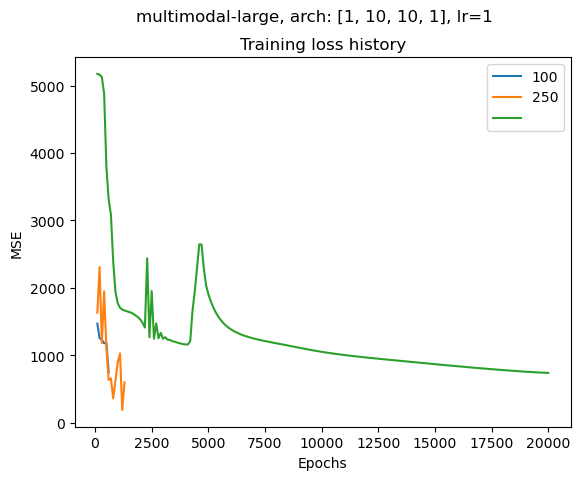

In [84]:
batch_test(multimodal_train, multimodal_test, [100, 250, None], [1, 10, 10, 1], 'xavier', lr=1, epochs=20000,
           name='multimodal-large', interval=100, cutoff=80)

W tym przypadku jest bardzo zdecydowana przewaga mniejszych batchów nad brakiem tworzenia batchy. Po ponad 100 sekundach i 20000 epokach algorytm bez batchy nie był nawet blisko zakładanego poziomu MSE, podczas gdy sieci z batchami osiągneły ten poziom dużo szybciej.